# Convolutional Neural Networks

CNNs are a twist on the neural network concept designed specifically to process data with spatial relationships. In the deep neural networks we've seen so far every node is always connected to every other node in the subsequent layer. While spatial relationships CAN be captured, as we've seen with out results on MNIST, the networks were not explicitly built with the assumption that spatial relationships definitely exist. Artificial neural networks are perfectly appropriate for data where the relationships are not spatial. 

But, for data such as images, it seems crazy to ignore the spatial relationships! For the vast majority of image data, neighboring pixels combined with each other tell us much more than combining the pixels in opposite corners or the image. CNN's rely on the assumption that our data has spatial relationships, and they have produced state-of-the-art results especially in image processing and computer vision. 

The fundamental unit of a CNN is a "convolution":

![](img/convolution.png)

> Image Source: https://github.com/PetarV-/TikZ/tree/master/2D%20Convolution

The key component of the convolution is called the kernel, which is a matrix. K in the image above. The kernel has a shape, 3x3 in this example, but we can define the for each convolution. We "slide" the kernel across every 3x3 section of the image performing item-by-item multiplication, for example in the above image the 4 highlighted in green is produced by taking the values highlighted in red, multiplying the values in the same position in the kernel, and summing the result of those multiplications. Specifically:


```
position:  [0,0]   [0,1]   [0,2]     [1,0]   [1,1]   [1,2]     [2,0]   [2,1]   [2,2]
operation: (1*1) + (0*0) + (0*1)  +  (1*0) + (1*1) + (0*0)  +  (1*1) + (1*0) + (1*1) == 4
```

This value is (optionally, but typically) then passed through a non-linearity like ReLU or Sigmoid before it is passed to the next layer. 

> Side note: In the literature, you'll discover that in a "true" convolution the kernel is inverted prior to the multiply+sum operation, and that this operation without the inversion is actually called "cross correlation" by most mathematicians. This matters in some contexts but we typically ignore it in deep learning because the values of the kernel are the things that are fine tuned, and storing them as "pre-inverted" matrixes is computationally efficent compared to inverting the kernel repeatedly. 

Here is a helpful animation to visualize convolutions:

![](img/animated-conv.gif)

> Image source: https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d

A convolutional layer has a few important properties:

* **Number of kernels** -- this is similar to the number of nodes in an ANN
    * Each kernel will be separately trained on the input data. 
    * Each kernel will produce an output layer, sometimes called a feature map.
    * These feature maps are used as input to the next layer.
* **Kernel size** -- these are almost always 3x3 or 5x5. 
    * Bigger kernels are more computationally expensive.
    * Bigger kernals have a wider "field of view" which can be helpful.
    * Dialted convolutions can capture a wider field of view at a lower computational cost (see additional resources).
* **Padding** -- notice above that a convolution produces a smaller output layer than the input layer by 1 pixel in each direction. Padding the input (typically with 0 values) allows the convolution to produce an output with the same size as the input. 
    * Downsampling to smaller sizes isn't always bad.
    * It reduces the computational costs at the next layer. 
    * If we don't pad, it limits the possible depth of the network esp. for small inputs
    * Padding tends to preserve information at the borders. If your images have important features on the edges, padding can improve performance
* **Stride** -- in the above we "slide" the kernel over by 1 pixel at every step. Increasing the stride increases the amount we slide by. 
    * Stride is typically set to 1. 
    * Higher values reduce the amount of information captured.
    * Higher values are more computationally efficent, as fewer values are combined per convolution.

One last important concept before we build a CNN: pooling. Pooling is a tactic used to decrease the resolution of our feature maps, and it is largely an issue of computational efficency. There are 2 popular kinds, max pooling and average pooling. Pooling layers use a window size, say 2x2, and take either the max or average value within each window to produce the output layer. The windows are almost always square, and the stride size is almost always set to the size of the window:

![](img/maxpool.jpeg)

> Image source: https://cs231n.github.io/convolutional-networks/

It is worth noting that pooling has fallen out of favor in a lot of modern architectures. Many machine learning practitioners have started downsampling through convolutions with larger stride sizes instead of pooling. 

### Building Our First CNN

Let's use Keras to build a CNN now.

In [1]:
# Setting up MNST, this should look familiar:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import fashion_mnist # BUT NOTE, this is not mnist, but fashion_mnist
from tensorflow.keras.models import Sequential

# Note, new layers
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, SpatialDropout2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

# For examining results
from sklearn.metrics import confusion_matrix
import seaborn as sn

num_classes = 10 
image_size = 784

(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()
training_data = training_images.reshape(training_images.shape[0], image_size) 
test_data = test_images.reshape(test_images.shape[0], image_size)

training_labels = to_categorical(training_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

4423680/4422102 [==============================] - 1s 0us/step


## Critically, Our Training/Test Data will Remain 2D

And with RGB images it will be 3D: Hight by width by color-cchannels: 1 in b/w, 3 in RGB, and if working with something like CMYK images for some reason, it'd be four. As we'll see, deeper layers in a CNN will commonly have many "color channel" layers, although we'll call them feature-maps or filter-maps since they're the result of computation rather than strictly the color values.

In [2]:
conv_training_data = training_images.reshape(60000, 28, 28, 1)
conv_test_data = test_images.reshape(10000, 28, 28, 1)

## This should look pretty familiar, just for plotting our training epochs

In [3]:
def plot_training_history(history, model, eval_images=False):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()
    
    if eval_images:
        loss, accuracy  = model.evaluate(conv_test_data, test_labels, verbose=False)
    else:
        loss, accuracy  = model.evaluate(test_data, test_labels, verbose=False)
        
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

# Fashion MNIST is a More Challenging Dataset

This time, we're using a new dataset called "Fashion MNIST". Like the handwritten digits dataset, this is a set of grayscale images each 28 by 28 pixels. However, the subject of these images is very different from the handwritten digits dataset. Instead, these are images of fashion objects. 

This dataset was built as a "drop in" replacement for MNIST because neural networks can solve the MNIST digits problem a bit too easily. 

Let's take a look at some:

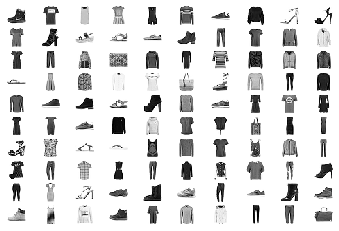

In [4]:
# Lets visualize the first 100 images from the dataset
for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    ax.axis('off')
    plt.imshow(training_images[i], cmap='Greys')

In [5]:
i = 0 # So we can look at one at a time...

# So we can see the label
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

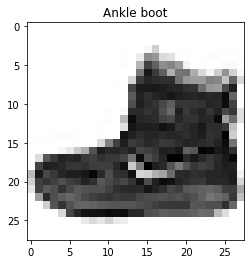

In [6]:
label = np.argmax(training_labels[i])
plt.title(label_map[label])
plt.imshow(training_images[i], cmap='Greys')
i += 1

Once again, there are 10 classes of image:

0 	T-shirt/top  
1 	Trouser  
2 	Pullover  
3 	Dress  
4 	Coat  
5 	Sandal  
6 	Shirt  
7 	Sneaker  
8 	Bag  
9 	Ankle boot  

As you might guess, this is a bigger challenge than the handwritten digits. Firstly, at 28 by 28 pixels much more fidelity is lost in this dataset compared to the digits dataset. Secondly, more pixels matter. In the digits dataset, we rarely care about the weight of the pixel, more or less what matters is if it's white or something else—we mostly cared about the edges between where someone had drawn and where they had not. Now internal differences in grayscale intensity are more informative, and comprise a larger amount of the image.

## For Comparison, A Traditional ANN

Let's quickly verify that a standard ANN that worked well in the context of MNIST does less well in Fashion MNIST:

In [7]:
# Recall from the Optimizers section that we were able to get 
# ~97% test accuracy with this network on regular MNIST:
model = Sequential()

model.add(Dense(units=512, activation='relu', input_shape=(image_size,)))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 575,050
Trainable params: 575,050
Non-trainable params: 0
_________________________________________________________________


Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 4s 83us/sample - loss: 2.1988 - accuracy: 0.7523 - val_loss: 0.5793 - val_accuracy: 0.8090
Epoch 2/10
54000/54000 [==============================] - 3s 47us/sample - loss: 0.5027 - accuracy: 0.8276 - val_loss: 0.4774 - val_accuracy: 0.8402
Epoch 3/10
54000/54000 [==============================] - 2s 46us/sample - loss: 0.4220 - accuracy: 0.8498 - val_loss: 0.4867 - val_accuracy: 0.8275
Epoch 4/10
54000/54000 [==============================] - 3s 63us/sample - loss: 0.3840 - accuracy: 0.8633 - val_loss: 0.4071 - val_accuracy: 0.8655
Epoch 5/10
54000/54000 [==============================] - 4s 80us/sample - loss: 0.3574 - accuracy: 0.8717 - val_loss: 0.4348 - val_accuracy: 0.8503
Epoch 6/10
54000/54000 [==============================] - 3s 49us/sample - loss: 0.3446 - accuracy: 0.8761 - val_loss: 0.3763 - val_accuracy: 0.8713
Epoch 7/10
54000/54000 [==============================] -

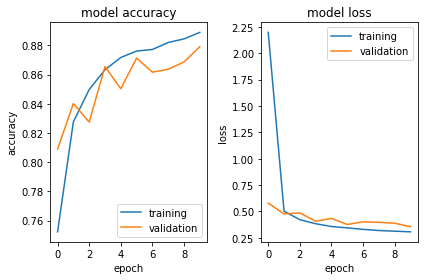

Test loss: 0.377
Test accuracy: 0.871


In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_data, training_labels, batch_size=128, epochs=10, verbose=True, validation_split=.1)
plot_training_history(history, model)

### Notes

Not bad, but not nearly as good as we were able to achieve with regular MNIST. And, looks like during the last few epochs we may have started to overfit. Some regularization e.g. Dropout could help.  

## Now, Lets Build a CNN

In [9]:
# The model is still sequentail, nothing new here.
model = Sequential()

# add model layers. The first parameter is the number of filters to make at each layer.
# Meaning here the result of the first layer is 64 different "feature maps" or "activation maps"

# Note, typically we still have to specify the input shape.
# There are some caveats to this detailed below, though.
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',))

# Flatten turns our final convolutional layer's output shape from (28, 28, 32) => 1x25088 (!)
model.add(Flatten())

# The tail of the network is a standard ANN and can also be deep or shallow depending
# on the network architecture.
model.add(Dense(512))
model.add(Dense(num_classes, activation='softmax'))

# Lets fit it with identical parameters and see what happens...
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 12,870,826
Trainable params: 12,870,826
Non-trainable params: 0
_________________________________________________________________


# 12,870,826 Parameters?!

That flatten layer into a 512 layer is exploding the parameter count. We're going to have to solve this problem or buy a very nice GPU (or both). This is something CNN designers must be aware of, that the parameter counts can explode when we transition to the flat ANN portion of the network. 

We'll use heavy striding as well as a new type of layer called GlobalAveragePooling to mitigate this problem soon.

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 115s 2ms/sample - loss: 6.0057 - accuracy: 0.7991 - val_loss: 0.4680 - val_accuracy: 0.8293
Epoch 2/10
54000/54000 [==============================] - 113s 2ms/sample - loss: 0.3998 - accuracy: 0.8576 - val_loss: 0.4450 - val_accuracy: 0.8417
Epoch 3/10
54000/54000 [==============================] - 112s 2ms/sample - loss: 0.3614 - accuracy: 0.8668 - val_loss: 0.4632 - val_accuracy: 0.8490
Epoch 4/10
54000/54000 [==============================] - 124s 2ms/sample - loss: 0.3397 - accuracy: 0.8767 - val_loss: 0.4203 - val_accuracy: 0.8540
Epoch 5/10
54000/54000 [==============================] - 118s 2ms/sample - loss: 0.3088 - accuracy: 0.8862 - val_loss: 0.4564 - val_accuracy: 0.8492
Epoch 6/10
54000/54000 [==============================] - 118s 2ms/sample - loss: 0.3001 - accuracy: 0.8902 - val_loss: 0.4600 - val_accuracy: 0.8562
Epoch 7/10
54000/54000 [===========================

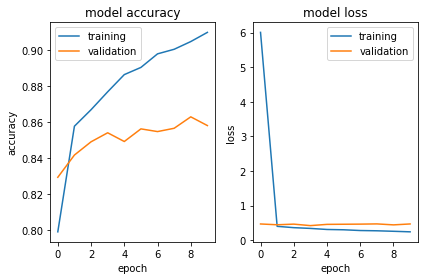

Test loss: 0.457
Test accuracy: 0.859


In [10]:
# Note the use of conv_training_data (28,28,1,n_samples) instead of training_data (784, n_samples)
# training_data => 784 long vector
# conv_training_data => 28 x 28 x 1 matrix

history = model.fit(
    conv_training_data, 
    training_labels, 
    batch_size=128, 
    epochs=10, 
    verbose=True, 
    validation_split=.1
)

plot_training_history(history, model, eval_images=True)

# Notes

### Expensive Computation

It took **forever**. CNN's tend to be more computationally intensive than ANN's, both because of the transition from the CNN to ANN portion explodes the number of weights, but also because the actual convolutional operation is expensive in and of itself.

We will address some of this problem with striding/pooling layers and global average pooling instead of flatten. CNN operations are also highly parallizable, so a good GPU can make a huge difference. This saved version of the notebook was executed on a commodity CPU.

### Overfitting

CNN's, like all their neural network cousins, have a strong capacity for overfitting. We can apply standard dropout on the final ANN layers as usual, and we'll introduce something called "spatial dropout" that is a unique regularization techniqe for CNN layers.

### Performance

Minute for minute the ANN improved faster, but epoch for epoch the CNN did better. Both of these measures ultimately matter for different reasons. CNN's can learn the features of an image having seen that image fewer times, although it looks at each image "more carefully" during each epoch. This gets us closer to "few shot" and "one shot" learning, which matters for online learning for example, and is a major goal of AI research.

At budget time, the minute for minute measure matters more though. You're paying for the energy or CPU/GPU time you use and CNN's tend to be more expensive in terms of cost per percentage-point-of-accuracy. However, the SOTA CNN's all outperform the SOTA ANN's in terms of top-line accuracy measures, so if you NEED a system that is highly accurate you'll probably need to suffer the addditional costs of a CNN.


## A Helpful View Into The Performance:

lets look at a "confusion matrix" to see what kinds of misclassifications our network made. This can be very useful in situatioons where some types of misclassification are "acceptable" such as a Sneaker classified as an Ankle Boot. In other cases, say "maliginant tumor" vs "benign tumor" such a miss is not acceptable.

Knowing **how** your model fails can be very useful, and an important part of risk assessment.

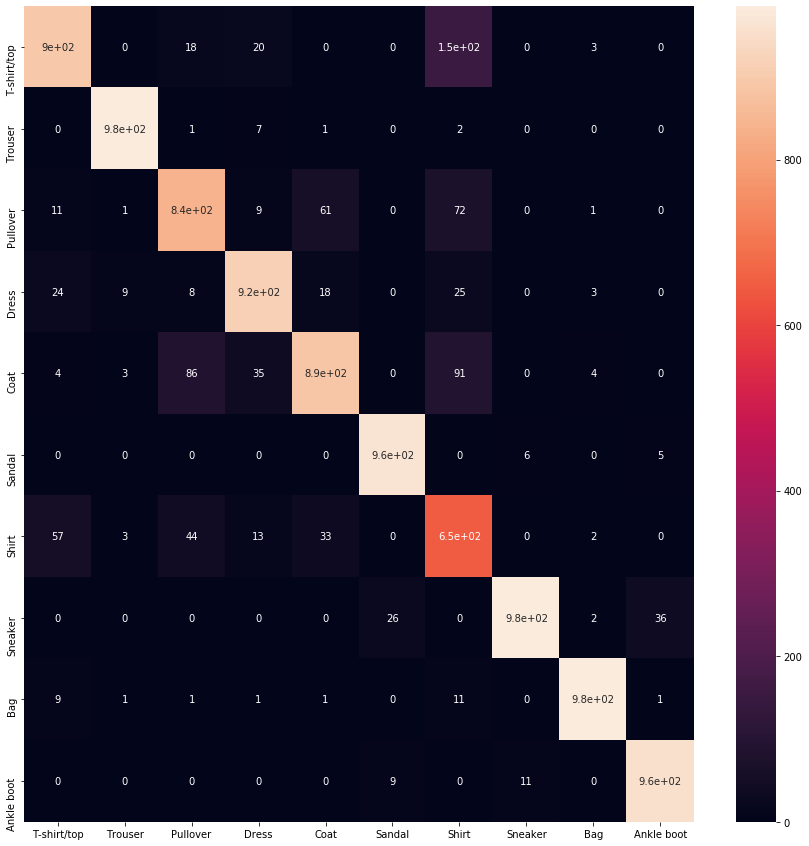

In [12]:
# When did our evaluator do poorly?
predictions = model.predict(conv_test_data)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1))
plt.figure(figsize = (15, 15))

name_labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

# A Less Naive CNN

We're going to apply a few best practicess to our CNN architecture now to address the problems we saw in our naive network.

## Striding (Formerly Pooling)

When we use strides we'll be reducing the size of the output filter-maps compared to the input features. 2x2 strides with padding cuts the input size in half! This will have two major impacts on our network:

1. Like in ANN's, we're trying to force the network to condense the relevant information into a smaller size. Leaving behind noise and extracting signal. This is part of why CNN's are sometimes refered to as "feature extractors."

2. This can have an enormous impact on the speed of the network. By shrinking the filter-maps at each layer we can afford to use more layers.

> Note: Earlier in the history of CNNs it was more common to use an unstrided convolutional layer followed by a max pooling layer to acheive these same two goals. That has become much less popular as striding has been shown to have roughly the same impact in terms of the second goal (increase information density) and striding is significantly faster computationally than unstrided convolutions followed by pooling.

## Dropout and Spatial Dropout

Regular Dropout can be used on the ANN sections of our networks. Spatial dropout is a very similar idea that drops out entire kernals at a time.

## Global Average Pooling

Global average pooling is an alternative to Flatten. Instead of preserving all the values and simply reshaping them into a flat vector global average pooling returns the average of all the values in a single filter map. This does represent a loss of some of the spatial information, and isn't always appropriate (flatten is better for object localization for example) but really helps with the parameter explosion when transition to dense layers.

> Note: GAB layers also allow us to accept arbitrary input sizes, rather than a fixed input size, since the number of paramters after the flatten layer becomes independent of the number of pixels in the input. Instead, only the number of filters in the final convolutional layer matters. This isn't used that commonly because simply reshaping images is pretty easy (as you'll see in later sections) but it is an interesting property that can be useful.

In [9]:
# Lets make a few small changes, including a dropout layer, and add some MaxPooling layers to see what happens
model = Sequential()

# Note, strides will shrink the output size.
model.add(Conv2D(64, kernel_size=(5, 5), strides=(2,2), activation='relu', padding='same', input_shape=(28, 28, 1)))

# Note, we INCREASED the number of filters as we're decreasing the size of each one.
# this is fairly common, especially if the number of classes is very high. 
# It has been shown that individual kernals tend to focus on individual classes esp. 
# w/ GlobalAveragePooling and at later layers
model.add(Conv2D(128, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
model.add(SpatialDropout2D(rate=0.2))

model.add(Conv2D(265, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
model.add(SpatialDropout2D(rate=0.2))

# GAB instead of Flatten, which will be a huge paramter saving move.
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# A bit of standard dropout
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 265)         305545    
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 4, 4, 265)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 265)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

## Notes:

Way fewer parameters, nice. 

Note the shape of the outputs, the final convolutional layer is only producing 4x4 feature maps but 256 of them.

Lets see how it does...

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 11s 199us/sample - loss: 0.7689 - accuracy: 0.7271 - val_loss: 0.4121 - val_accuracy: 0.8473
Epoch 2/10
54000/54000 [==============================] - 5s 100us/sample - loss: 0.4295 - accuracy: 0.8489 - val_loss: 0.3410 - val_accuracy: 0.8793
Epoch 3/10
54000/54000 [==============================] - 5s 100us/sample - loss: 0.3563 - accuracy: 0.8731 - val_loss: 0.3126 - val_accuracy: 0.8840
Epoch 4/10
54000/54000 [==============================] - 6s 103us/sample - loss: 0.3211 - accuracy: 0.8846 - val_loss: 0.2859 - val_accuracy: 0.8952
Epoch 5/10
54000/54000 [==============================] - 6s 113us/sample - loss: 0.2945 - accuracy: 0.8948 - val_loss: 0.2753 - val_accuracy: 0.8977
Epoch 6/10
54000/54000 [==============================] - 6s 112us/sample - loss: 0.2730 - accuracy: 0.8994 - val_loss: 0.2697 - val_accuracy: 0.9007
Epoch 7/10
54000/54000 [==========================

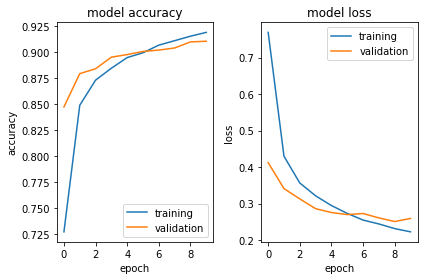

Test loss: 0.275
Test accuracy: 0.906


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=10, verbose=True, validation_split=.1)

plot_training_history(history, model, eval_images=True)

## Notes:

Much faster, as we had hoped.

Much lesss overfitting, as we had hoped. 

Better top-line validation and test accuracies. 

Win, win, win.

For fun, lets look at the confusion matrix again.

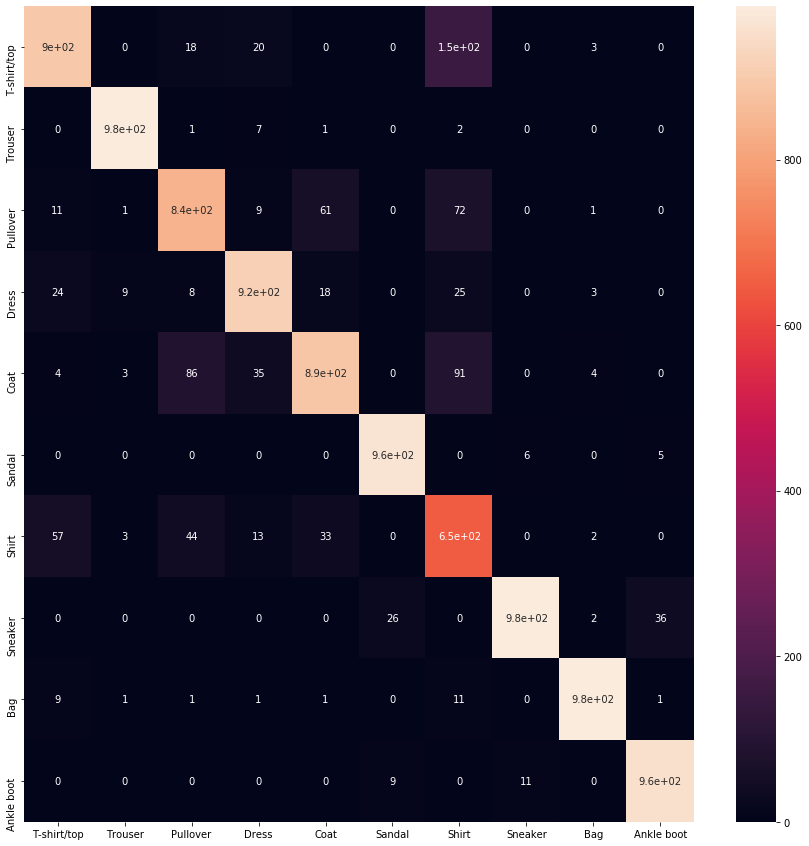

In [13]:
predictions = model.predict(conv_test_data)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1))
plt.figure(figsize = (15, 15))

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

90% is pretty respectible, especially considering how speedy training was, and given that we didn't apply any data augmentation. [Some state of the art networks get around 93-95% accuracy](https://github.com/zalandoresearch/fashion-mnist). It's also worth noting that we mostly fail on comparing pullovers to coats, and tops to t-shirts. Those are kind of acceptable, it's not like we're calling shoes coats or something like that.

## Mini-Exercise:

Using what you've learned build a CNN architecture and train it. See if you can do better than the network we just trained!

In [17]:
# Your code here... don't forget to plot your training epochs and maybe look at the confusion matrix!
# Lets make a few small changes, including a dropout layer, and add some MaxPooling layers to see what happens
model = Sequential()

# Note, strides will shrink the output size.
model.add(Conv2D(64, kernel_size=(5, 5), strides=(2,2), activation='relu', padding='same', input_shape=(28, 28, 1)))

# Note, we INCREASED the number of filters as we're decreasing the size of each one.
# this is fairly common, especially if the number of classes is very high. 
# It has been shown that individual kernals tend to focus on individual classes esp. 
# w/ GlobalAveragePooling and at later layers
model.add(Conv2D(256, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
model.add(SpatialDropout2D(rate=0.2))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
model.add(SpatialDropout2D(rate=0.2))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
model.add(SpatialDropout2D(rate=0.2))

model.add(Conv2D(256, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
model.add(SpatialDropout2D(rate=0.2))

# GAB instead of Flatten, which will be a huge paramter saving move.
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))

# A bit of standard dropout
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 256)         147712    
_________________________________________________________________
spatial_dropout2d_6 (Spatial (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 32)          73760     
_________________________________________________________________
spatial_dropout2d_7 (Spatial (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 32)          9248      
_________________________________________________________________
spatial_dropout2d_8 (Spatial (None, 2, 2, 32)         

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 11s 200us/sample - loss: 0.7064 - accuracy: 0.7491 - val_loss: 0.4074 - val_accuracy: 0.8475
Epoch 2/10
54000/54000 [==============================] - 9s 164us/sample - loss: 0.4326 - accuracy: 0.8472 - val_loss: 0.3473 - val_accuracy: 0.8727
Epoch 3/10
54000/54000 [==============================] - 8s 149us/sample - loss: 0.3758 - accuracy: 0.8661 - val_loss: 0.3204 - val_accuracy: 0.8802
Epoch 4/10
54000/54000 [==============================] - 8s 157us/sample - loss: 0.3434 - accuracy: 0.8771 - val_loss: 0.3125 - val_accuracy: 0.8867
Epoch 5/10
54000/54000 [==============================] - 8s 150us/sample - loss: 0.3292 - accuracy: 0.8825 - val_loss: 0.2926 - val_accuracy: 0.8943
Epoch 6/10
54000/54000 [==============================] - 8s 154us/sample - loss: 0.3124 - accuracy: 0.8890 - val_loss: 0.2985 - val_accuracy: 0.8925
Epoch 7/10
54000/54000 [==========================

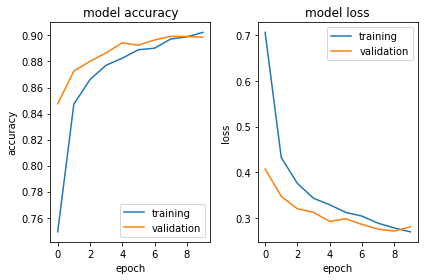

Test loss: 0.3
Test accuracy: 0.895


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=10, verbose=True, validation_split=.1)

plot_training_history(history, model, eval_images=True)

# Skip Layers


Skip layers allow us to send information directly from earlier layers to later layers without being transformed by the layers inbetween. This tactic was invented to solve a varient of the the "vanishing gradient" problem. With skip layers we can forward signals from the original image and layer them on top of activation maps produced at later layers. We also use the skip layers during backpropagation, which causes helps the gradient values flow backwards through the network without becoming so diminished that the early layers never change.

This tactic is only needed as our networks become very deep. Just like ANN's with Sigmoid layers, CNN's can suffer from a vanishing gradient problem and these skip layers were a massive innovation in the history of CNN's that has really allowed "deep" learning with CNNs to thrive. 

In the following example, the skip layers are overkill and probably won't even help much. But for completenes we should see how to build them as nearly every SOTA CNN architecture includes this concept.

In [16]:
# To use these, we need to use the non-sequential Model format
from tensorflow.keras.layers import Input, Add
from tensorflow.keras.models import Model

# First we make an input layer...
inputs = Input(shape=(28, 28,1))

# Each subsequent layer is called like a function with the layer(s) that should be the 
# inputs to this layer. These three each have a single input.
cnn_1 = Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(inputs)
cnn_2 = Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(cnn_1)
cnn_3 = Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(cnn_2)

# But this Add layer takes 2 inputs. 
# For Add layers, the two inputs being combined must be exactly the same shape.
# Those layers are lined up, and added "pixel-wise" or "matrix-cell-wise" to produce the 
# output layer, which will also be the same shape as the 2 input layers.
add = Add()([cnn_1, cnn_3])
cnn_4 = Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(add)

flat = GlobalAveragePooling2D()(cnn_4)

dense_1 = Dense(256, activation='relu')(flat)
drop = Dropout(rate=0.2)(dense_1)
classifier = Dense(num_classes, activation='softmax')(drop)

model = Model(inputs=inputs, outputs=classifier)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 32)   9248        conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 32)   9248        conv2d_6[0][0]                   
______________________________________________________________________________________________

## Notes:

Pay special attention to the add layer's "connected to" section. Nothing else here is particularly new or interesting, but this conecept is VERY important to SOTA CNNs. We'll see more advanced arcchitecturess applying this idea quite a lot.

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 35s 641us/sample - loss: 1.0091 - accuracy: 0.6506 - val_loss: 0.5542 - val_accuracy: 0.7965
Epoch 2/5
54000/54000 [==============================] - 35s 643us/sample - loss: 0.5398 - accuracy: 0.8059 - val_loss: 0.4535 - val_accuracy: 0.8362
Epoch 3/5
54000/54000 [==============================] - 34s 636us/sample - loss: 0.4458 - accuracy: 0.8419 - val_loss: 0.3817 - val_accuracy: 0.8650
Epoch 4/5
54000/54000 [==============================] - 34s 628us/sample - loss: 0.3958 - accuracy: 0.8595 - val_loss: 0.3528 - val_accuracy: 0.8757
Epoch 5/5
54000/54000 [==============================] - 37s 682us/sample - loss: 0.3608 - accuracy: 0.8706 - val_loss: 0.3466 - val_accuracy: 0.8785


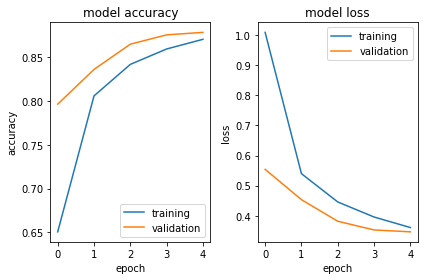

Test loss: 0.37
Test accuracy: 0.869


In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=5, verbose=True, validation_split=.1)

plot_training_history(history, model, eval_images=True)

# Performance notes:

We didn't expect this to do any better than the networks above. It doesn't have dropout, it's quite small parameterwise, and serves only as a simple example of skip layers.